## 读取数据

In [68]:
import numpy as np
import pandas as pd
from itertools import islice        # 需先安装 itertools
import matplotlib.pyplot as plt
import seaborn as sns  # 统计数据可视化
from scipy import stats
from sklearn.decomposition import PCA
def get_frequency(filename):
    str0 = ["a", "t", "c" , "g"]
    df_count = pd.DataFrame(columns=str0)		# 用于记录频数
    with open(path_data + 'Art-model-data.txt','r', newline='') as filereader:
        k = 0
        for row in islice(filereader, 1, None):   # islice() 跳过第1行
            if len(row)>2:    # 空行可能有换行符，占一定长度
                k = k+1
                k_count = []
                for item in str0:
                    k_count.append(row.count(item))
                df_count.loc[k] = k_count
    df_RowSum = df_count.sum(axis=1)  		# 按行相加，用于将频数转换为频率
    df_freq = df_count.div(df_RowSum, axis="rows")  # 每行除以对应总和， 按行计算频率
    return df_freq.astype("float").round(4)     	# 转换类型为浮点数后，只保留4位小数

path_data = "/home/carton/workspace/python/Multivariate-statistical-analysis/database/期末考核/"     # 设置 数据路径
file0 = path_data + 'Art-model-data.txt'
df_data = get_frequency(file0)

In [69]:
df_data

,a,t,c,g
1,0.2973,0.1351,0.1712,0.3964
2,0.2703,0.1532,0.1622,0.4144
3,0.2703,0.0631,0.2162,0.4505
4,0.4234,0.2883,0.1081,0.1802
5,0.2342,0.1081,0.2342,0.4234
6,0.3514,0.1261,0.1261,0.3964
7,0.3514,0.1892,0.0991,0.3604
8,0.2793,0.1892,0.1622,0.3694
9,0.2072,0.1532,0.2072,0.4324
10,0.1818,0.1364,0.2727,0.4091


## 探索性数据分析

可以看出数据在数量级上的差异程度，例如极大、极小值以及分布情况，用于判断是否需要做预处理

In [70]:
stats_dic = { "mean": "均值", "std": "标准差", "max": "极大值", "min": "极小值","skew":"偏度", "kurt":"峰度"}
df_data_stats = df_data.apply(stats_dic.keys())
df_data_stats = df_data_stats.rename(index=stats_dic) # 采用字典将指标替换为中文
df_data_stats.T.round(2)

,均值,标准差,极大值,极小值,偏度,峰度
a,0.29,0.06,0.42,0.18,0.09,-0.53
t,0.33,0.20,0.65,0.06,0.16,-1.76
c,0.14,0.07,0.27,0.00,-0.01,-0.59
g,0.24,0.16,0.45,0.06,0.17,-2.00


## 计算相关系数矩阵，绘制热力图来展示

In [71]:
df_corr = df_data.corr()
df_corr.head().round(4)

,a,t,c,g
a,1.0000,0.0448,-0.5025,-0.2285
t,0.0448,1.0000,-0.6873,-0.9467
c,-0.5025,-0.6873,1.0000,0.5935
g,-0.2285,-0.9467,0.5935,1.0000


<AxesSubplot: >

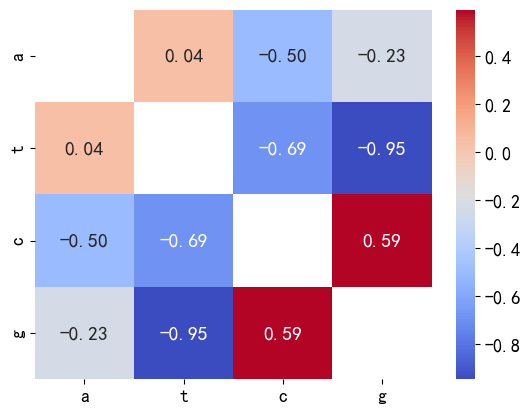

In [72]:
sns.heatmap(df_data.corr(),annot=True,fmt=".2f", cmap="coolwarm",annot_kws={ "size":14},mask=(df_data.corr()==1))

## 计算特征值和特征向量，进行排序

In [73]:
W,V = np.linalg.eig(df_corr) # 计算特征值和特征向量
sort_id = np.argsort(W)[::-1] # 升序排序后，逆转
W = W[sort_id]; V = V[:,sort_id]
print(W); print(V)
print("特征值之和为：{:.2f}".format(sum(W)))

[2.61129927e+00 1.06311439e+00 3.25586300e-01 4.04237424e-08]
[[ 0.262793    0.8517844   0.3852981   0.23863897]
 [ 0.56870537 -0.38235859  0.00635477  0.72824154]
 [-0.53374909 -0.25530554  0.75740616  0.27616464]
 [-0.56800172  0.25116595 -0.52710616  0.58004207]]
特征值之和为：4.00


## 调用PCA包计算特征值，贡献率，累计贡献率

In [74]:
pca_data = PCA() # 建立模型，用 PCA(n_components=2) 可指定主成分数目
df_tem = df_data.apply(stats.zscore,ddof=1) # 前面进行标准化处理的数据集
principalComponents=pca_data.fit_transform(df_tem)# 训练模型得PCA参数、得分
col_name = ["特征"+str(i) for i in range(1,pca_data.n_components_+1)]
# 自动生成 特征名称
df_res = pd.DataFrame(pca_data.components_.T, columns=col_name, index=df_data.columns[0:]) # 先转置，列为 特征名称, 行为变量名
df_res.loc["特征值",:] = pca_data.n_components_ * pca_data.explained_variance_ / pca_data.explained_variance_.sum()# 归一化处理， (若为协方差矩阵)原始数据 之和 不等于 变量个数
df_res.loc["贡献率",:] = pca_data.explained_variance_ratio_
df_res.loc["累计贡献率",:] = np.cumsum(pca_data.explained_variance_ratio_)
display(df_res)

,特征1,特征2,特征3,特征4
a,-0.262793,-0.851784,0.385298,-2.386390e-01
t,-0.568705,0.382359,0.006355,-7.282415e-01
c,0.533749,0.255306,0.757406,-2.761646e-01
g,0.568002,-0.251166,-0.527106,-5.800421e-01
特征值,2.611299,1.063114,0.325586,4.042374e-08
贡献率,0.652825,0.265779,0.081397,1.010594e-08
累计贡献率,0.652825,0.918603,1.000000,1.000000e+00


## 绘制碎石图

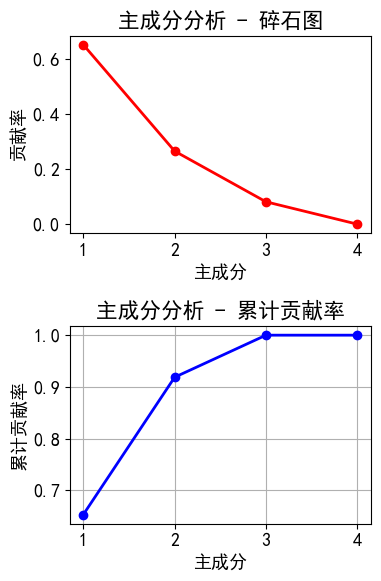

In [75]:
PC_values = np.arange(pca_data.n_components_)+1 # 主成分顺序
fig, axes = plt.subplots(2,1, figsize=(4,6))
axes[0].plot(PC_values, df_res.loc["贡献率",:], 'ro-', linewidth=2)
axes[0].set_xticks(PC_values)
axes[0].set_title('主成分分析 - 碎石图')
axes[0].set_xlabel('主成分'); axes[0].set_ylabel('贡献率')
axes[1].plot(PC_values, df_res.loc["累计贡献率",:], 
'bo-', linewidth=2)
axes[1].set_xticks(PC_values)
axes[1].set_title('主成分分析 - 累计贡献率')
axes[1].set_xlabel('主成分'); axes[1].set_ylabel('累计贡献率')
plt.grid() # 添加网格
plt.tight_layout() # 调整多图间距，避免重叠
plt.show()

## 绘制特征向量热力图分析

Text(0.5, 1.0, '特征向量热力图')

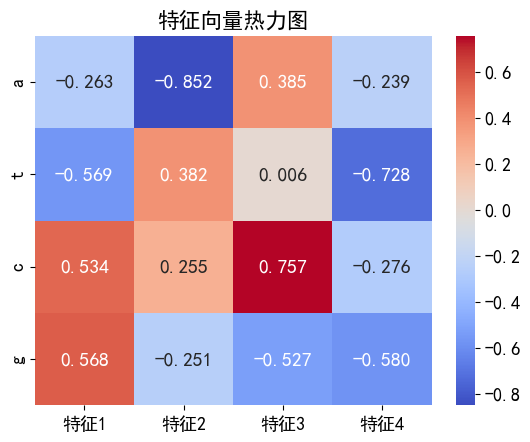

In [76]:
sns.heatmap(df_res.head(4), annot=True, fmt=".3f", annot_kws={ "size":14},cmap="coolwarm") # 提取特征向量值
plt.title("特征向量热力图")

## 计算样品的主成分得分值

In [77]:
df_pc = pd.DataFrame(data=principalComponents, columns=col_name) # 主成分得分值
df_pc = df_pc.set_index(df_data.index).copy() # 重新设置序号，以原始数据序号为准
df_pc

,特征1,特征2,特征3,特征4
1,1.333719,-0.599039,-0.160861,0.000144
2,1.392752,-0.264040,-0.476172,-0.000204
3,2.176982,-0.312536,-0.048523,-0.000249
4,-0.876455,-1.847136,0.690920,0.000056
5,2.225062,0.362477,0.011634,0.000435
6,0.812133,-1.493049,-0.297008,0.000226
7,0.301816,-1.404426,-0.449378,-0.000143
8,1.086400,-0.240675,-0.268176,-0.000247
9,2.042610,0.702796,-0.456611,0.000103
10,2.583524,1.271985,0.139556,-0.000024


## 绘制样品主成分散点图，分析含义
横坐标代表第一主成分，纵坐标代表第二主成分
可以通过分析横坐标最左端，最右端，纵坐标最左端，最右端分析主成分的实际含义

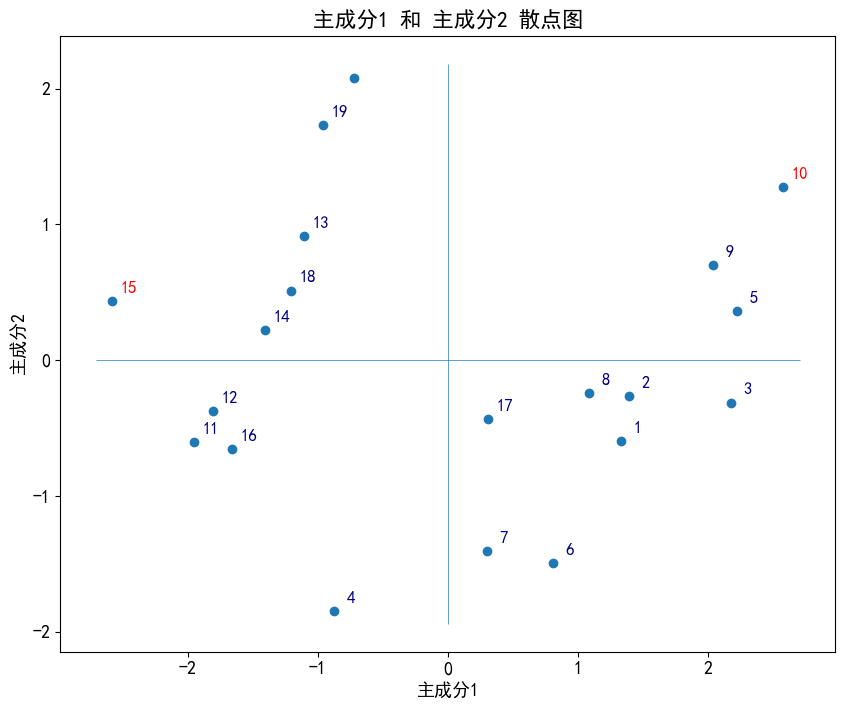

<Figure size 1920x1440 with 0 Axes>

In [78]:
plt.subplots(figsize=(10,8)) # 绘制 成分得分值图 —— 分析内涵
p_x=df_pc.iloc[:,0]; p_y=df_pc.iloc[:,1] # 选择主成分
R_x = np.max(p_x)-np.min(p_x) # range of p_x
R_y = np.max(p_y)-np.min(p_y) # range of p_y
plt.scatter(p_x,p_y)
d_pian = 0.05 # 标注文字时做一定偏移，避免覆盖散点
for i in range(1,len(df_pc)):
    if np.max(p_x) == p_x[i] or np.min(p_x) == p_x[i]:
        plt.text(p_x[i] + R_x*d_pian/2, p_y[i]+ R_y*d_pian/2, df_pc.index[i-1], color='red', ha='center', va='center',fontsize=12)
    else:
        plt.text(p_x[i] + R_x*d_pian/2, p_y[i]+ R_y*d_pian/2, df_pc.index[i-1], color='navy', ha='center', va='center',fontsize=12)
plt.xlabel("主成分{}".format(1)); plt.ylabel("主成分{}".format(2))
plt.hlines(0,np.min(p_x)*(1+d_pian),np.max(p_x)*(1+d_pian), linewidth=0.5)
plt.vlines(0,np.min(p_y)*(1+d_pian),np.max(p_y)*(1+d_pian), linewidth=0.5)
plt.title("主成分{} 和 主成分{} 散点图".format(1,2))
plt.figure(dpi=300)
plt.show()

## 构造线性分类器进行划分

In [79]:
df_pc["类别"] = df_pc["特征1"].apply(lambda x: "B" if x>0 else "A")

In [80]:
df_pc

,特征1,特征2,特征3,特征4,类别
1,1.333719,-0.599039,-0.160861,0.000144,B
2,1.392752,-0.264040,-0.476172,-0.000204,B
3,2.176982,-0.312536,-0.048523,-0.000249,B
4,-0.876455,-1.847136,0.690920,0.000056,A
5,2.225062,0.362477,0.011634,0.000435,B
6,0.812133,-1.493049,-0.297008,0.000226,B
7,0.301816,-1.404426,-0.449378,-0.000143,B
8,1.086400,-0.240675,-0.268176,-0.000247,B
9,2.042610,0.702796,-0.456611,0.000103,B
10,2.583524,1.271985,0.139556,-0.000024,B


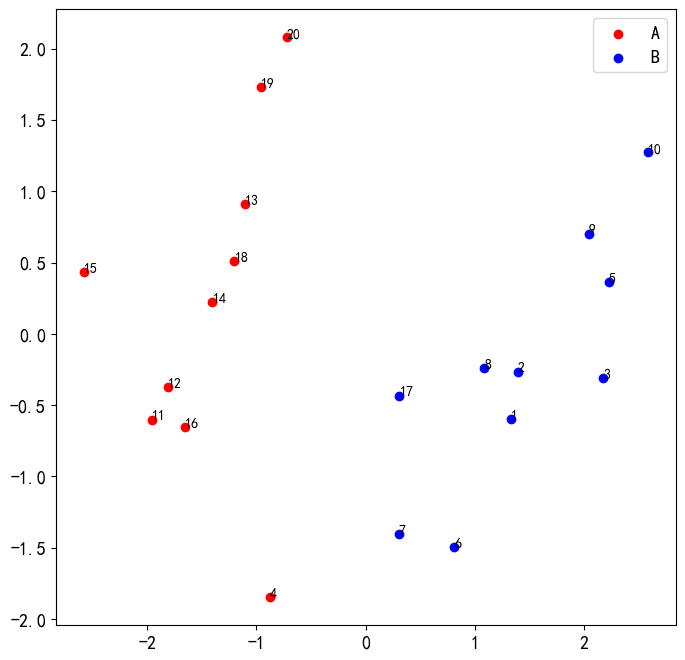

In [90]:
plt.figure(figsize=(8,8))
plt.scatter(df_pc.loc[df_pc["类别"]=="A","特征1"],df_pc.loc[df_pc["类别"]=="A","特征2"],c="r",label="A")
plt.scatter(df_pc.loc[df_pc["类别"]=="B","特征1"],df_pc.loc[df_pc["类别"]=="B","特征2"],c="b",label="B")
for i in range(len(df_pc)):
    plt.text(df_pc.iloc[i,0],df_pc.iloc[i,1],df_pc.index[i],fontsize=10)
plt.legend()
plt.show()

用了主成分分析，横坐标是主成分一，纵坐标是成分二， 主成分2中AT的比例高，所以构造了一个线性分类器，主成分二高的就是A类，反之就是B类